In [1]:
# so will label user as poly and mono based on the tweets
# will further classify poly into 
    # talk about drug after their first mention of juul
    # talk d before their mention of juul

In [3]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook as tqdm

/home/akshayuppal2345/.local/lib/python3.5/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [4]:
import pandas as pd
import numpy as np
import nltk
import tweepy
import matplotlib.pyplot as plt
import pickle
import ast
import networkx as nx

In [47]:
pd.set_option('display.max_colwidth', -1)

In [8]:
# need to change with 3200 limit data
df_timeline = pickle.load(open("/home/akshayuppal2345/twitter_juul/models/df_timeline_lbl.pkl","rb"))

In [23]:
len(df_timeline)

1204733

In [10]:
a =  df_timeline.groupby("userID")['tweetText'].agg("count")

In [12]:
users = list(a.index)
len(users)

7371

In [ ]:
plt.plot(np.arange(0,len(a)),a.values)
plt.show()

In [ ]:
df_user1 = df_timeline[df_timeline.userID == users[0]]


# need watson classifier for categorical classification

In [ ]:
# next user watson to classify text into categories
df_user1.loc[df_user1.tweetText.str.contains(pattern)]

In [ ]:
poly_user = list()
for user in tqdm(users):
    df_temp = df_timeline[df_timeline.userID == user]
    if(len(df_temp.loc[df_temp.tweetText.str.contains(pattern)]) > 0):
        poly_user.append(user)

In [ ]:
ex = df_timeline.loc[df_timeline.userID == poly_user[1]]
ex.loc[ex.tweetText.str.contains(pattern)]

In [ ]:
# so will create embeddings for our tweets and manually label 500 of the tweet containing weeds and classify them 
# them as substance abouse or not

In [ ]:
len(df_timeline.tweetText)

In [10]:
# dump the updated weed words in models directory
with open("/Users/akshayuppal/Desktop/thesis/twitter_juul/models/weed_words.pkl","wb") as f:
    pickle.dump(weed_words,f)

In [11]:
weed_words = [(" " + word+" ") for word in weed_words]
pattern = "|".join(weed_words)

In [12]:
pattern

' weed | ganja | marijuana | grass | cannabis | pot | smoke | mary jane | hemp | marihuana | hash | reefer | hashish | herb | bhang | green goddess | locoweed | maryjane | bud | spliff | wacky baccy | joint | sinsemilla | doobie | tobacco | acapulco gold '

In [26]:
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akshayuppal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshayuppal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### tokenize the sentences for the gensim.. we are going to classify the  sentences as weeds or not.. manual label(500 sent)

### extracting the data

In [22]:
df_timeline = pd.read_csv("~/Desktop/thesis/backup_stuff/userTimelineData.csv",lineterminator="\n")

In [23]:
# keeping only english tweets
df_timeline = (df_timeline[df_timeline.lang == 'en'])

In [24]:
# filter those that contain the occurance of weed or similar words
df_tweet_weeds = df_timeline[df_timeline['tweetText'].str.contains(pattern, case = False)]

NameError: name 'pattern' is not defined

In [ ]:
df_nonweed = (df_timeline.loc[~df_timeline.index.isin(df_tweet_weeds.index)])

In [ ]:
# taking sample of size weed tweets
df_nonweed =(df_nonweed.sample(frac=1))
nonweed_sample = df_nonweed[:len(df_tweet_weeds)]

In [ ]:
# randomize the data before creating embedding 
df_tweet_weeds =(df_tweet_weeds.sample(frac=1))

In [ ]:
weed_sample = (df_tweet_weeds)

In [ ]:
mix_sample = weed_sample.append(nonweed_sample)

In [ ]:
#randomize weed and non weed tweets
mix_sample = (mix_sample.sample(frac=1))

In [20]:
len(mix_sample)

48622

In [8]:
import nltk
# for df
def get_tokenize_words(text):
    tkz = nltk.tokenize
    words = tkz.word_tokenize(text)
    words = [ele for ele in words if ((ele not in stopwords) and len(ele)>2 and (ele.isalpha()))]
    words = [word.lower() for word in words]
    return words

In [9]:
def hashtag_count(df):
    if df is not np.nan:
        hashtags = ast.literal_eval(df)
        if (hashtags is not None):
            return (len(hashtags))
        else:
            return (0)
    else:
        return (0)

In [10]:
def count_words(sentence):
    words = get_tokenize_words(sentence)
    return len(words)

In [11]:
def get_words(sentence):
    words = get_tokenize_words(sentence)
    return (words)

In [12]:
# @param dataframe
def get_sentences(df,column):
    sentences = list(df[column].progress_apply(get_tokenize_words))
    return(sentences)

In [13]:
# @param dataframe --slow not , using above
def get_sentences1(df,column):
    if column in df:
        sentences = list()
        for index,row in tqdm(df.iterrows(),total=len(df)):
            words = get_words(row[column])
            sentences.append(words)
        return(sentences)

In [14]:
# class that returns word2vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in tqdm(X)
        ])

In [15]:
## adding further features for the tweets
from collections import Counter
def create_features(df):
    df_new = pd.DataFrame([])
    if ('tweetText' in df.columns):
        df_new['no_urls'] = df['tweetText'].str.count(r'(https?://\S+)')
        df_new['no_authors'] = df['tweetText'].str.count(r'(\@\w+)')
        if ('hashtags' in df.columns):
            df_new['no_hashtags'] = df['hashtags'].apply(hashtag_count)
        # modifying the text after we got the features
        tweet_texts = pd.DataFrame(df['tweetText'].str.replace(r'(https?://\S+)',""))  # urls
        tweet_texts = pd.DataFrame(df['tweetText'].str.replace(r'(\@\w+)',"author"))  # author mentions
        tweet_texts = pd.DataFrame(df['tweetText'].str.replace(r'(\#\w+)',""))         # removing hashtags
        df_new['tweetText'] = tweet_texts
        df_new['no_words'] = df['tweetText'].apply(lambda x: len(x.split(' ')))
        return(df_new)

In [16]:
# combination of meanembeddignvecotrizer and create_features
# param sentences, w2v model, full dataframe with all columns
def get_X(sentences,w2v,df,features='w2v'):
    ob = MeanEmbeddingVectorizer(w2v)
    w2v_features = ob.transform(sentences)
    # getting other features
    if (features == 'both'):
        df_temp = create_features(df)
        tweet_features = df_temp.loc[: , df_temp.columns !='tweetText']
        X = np.hstack((w2v_features,tweet_features))
        return X
    else:
        return(w2v_features)

### Extracting features

In [647]:
## getting other features
mix_sample['no_urls'] = mix_sample['tweetText'].str.count(r'(https?://\S+)')
mix_sample['no_authors'] = mix_sample['tweetText'].str.count(r'(\@\w+)')
mix_sample['no_hashtags'] = mix_sample['hashtags'].apply(hashtag_count)

In [381]:
# modifying the text after we got the features
def clean_text(df,column):
    if (column in df.columns):
        tweet_texts = pd.DataFrame(df.column.str.replace(r'(https?://\S+)',""))  # urls
        tweet_texts = pd.DataFrame(df.column.str.replace(r'(\@\w+)',"author"))  # author mentions
        tweet_texts = pd.DataFrame(tweet_texts.column.str.replace(r'(\#\w+)',""))         # removing hashtags
        return df

In [649]:
mix_sample['tweetText'] = tweet_texts

In [650]:
# count words after we remove all of the other things(urls, authors, hashtags) # replace if find better
mix_sample['no_words'] = mix_sample['tweetText'].progress_apply(count_words)








  0%|          | 0/48622 [00:00<?, ?it/s]






  0%|          | 207/48622 [00:00<00:23, 2060.85it/s]






  1%|          | 439/48622 [00:00<00:22, 2129.85it/s]






  1%|▏         | 692/48622 [00:00<00:21, 2235.80it/s]






  2%|▏         | 950/48622 [00:00<00:20, 2326.07it/s]






  2%|▏         | 1190/48622 [00:00<00:20, 2346.42it/s]






  3%|▎         | 1444/48622 [00:00<00:19, 2397.85it/s]






  3%|▎         | 1685/48622 [00:00<00:19, 2399.89it/s]






  4%|▍         | 1910/48622 [00:00<00:19, 2352.04it/s]






  4%|▍         | 2135/48622 [00:00<00:20, 2289.37it/s]






  5%|▍         | 2372/48622 [00:01<00:20, 2311.74it/s]






  5%|▌         | 2608/48622 [00:01<00:19, 2319.06it/s]






  6%|▌         | 2837/48622 [00:01<00:20, 2267.19it/s]






  6%|▋         | 3076/48622 [00:01<00:19, 2302.45it/s]






  7%|▋         | 3305/48622 [00:01<00:19, 2268.91it/s]






  7%|▋         | 3537/48622 [00:01<00:19, 2281.49it/s]






  8%|▊         | 3765/48622 [00:01

In [183]:
## getting the sentences 
sentence = get_sentences(mix_sample,'tweetText')

100%|██████████| 48622/48622 [00:22<00:00, 2147.23it/s]


## dimensions of w2v is 10
#### 100 dim gave lower accuracy {train = 0.583547557840617, test = 0.5615384615384615}
#### and also low for 20 dim {train = 0.50 , test = .60}

In [20]:
# word 2 vec 
model = Word2Vec(sentences_timeline, size=20,min_count=2)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

NameError: name 'sentences_timeline' is not defined

In [5]:
# pickle the w2v word vectors  
import pickle
with open("/Users/akshayuppal/Desktop/thesis/twitter_juul/models/w2v.pkl","wb") as f:
    pickle.dump(w2v,f)

NameError: name 'w2v' is not defined

## might as well user glove for word vectors and then take average of the vectors.. @TODO

In [29]:
#open the w2v model
w2v = pickle.load(open("/Users/akshayuppal/Desktop/thesis/twitter_juul/models/w2v.pkl","rb"))

In [30]:
w = 'legal'
model.wv.most_similar(positive=w)

NameError: name 'model' is not defined

In [657]:
model.wv.similarity(w1='pot',w2='cannabis')

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.8429552

In [273]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [660]:
model.wv.similarity(w1='weed',w2='high')

/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.55198026

In [662]:
ob = MeanEmbeddingVectorizer(w2v)
w2v_features = ob.transform(sentences)








  0%|          | 0/48622 [00:00<?, ?it/s]






  4%|▍         | 1896/48622 [00:00<00:02, 18957.35it/s]






  8%|▊         | 3727/48622 [00:00<00:02, 18756.76it/s]






 12%|█▏        | 5610/48622 [00:00<00:02, 18778.56it/s]






 14%|█▍        | 6875/48622 [00:00<00:02, 16392.98it/s]






 18%|█▊        | 8720/48622 [00:00<00:02, 16958.67it/s]






 22%|██▏       | 10752/48622 [00:00<00:02, 17843.31it/s]






 26%|██▌       | 12737/48622 [00:00<00:01, 18399.59it/s]






 30%|███       | 14679/48622 [00:00<00:01, 18692.00it/s]






 34%|███▍      | 16664/48622 [00:00<00:01, 19024.19it/s]






 38%|███▊      | 18705/48622 [00:01<00:01, 19418.88it/s]






 43%|████▎     | 20687/48622 [00:01<00:01, 19534.96it/s]






 47%|████▋     | 22676/48622 [00:01<00:01, 19637.17it/s]






 51%|█████     | 24623/48622 [00:01<00:01, 19586.26it/s]






 55%|█████▍    | 26599/48622 [00:01<00:01, 19635.89it/s]






 59%|█████▉    | 28626/48622 [00:01<00:01, 19821.21it/s]






 63%|

In [663]:
df_input_data = mix_sample[['no_hashtags','no_urls','no_words','no_authors']]

In [664]:
## this is all of the data  ## can predit this..
input_data = np.hstack((df_input_data.values,w2v_features))

In [665]:
len(input_data)

48622

### Labelled_data

In [617]:
# so now to classify the text as substance abuse or not based on the tags..annotated
# so now will annotate the 500 sentences containing of weed words.. 
# going to label promotions and news as non weed
# labels (news: 1, research or study:2 , user_tweet: 3)

In [623]:
len(mix_sample)

48622

### dumnping file -- delete

In [669]:
# the data is mixed so taking a set of 500 tweets -- delete dumpinmg file
to_annotate = pd.DataFrame(mix_sample[401:500]['tweetText'])
to_annotate.to_csv("/Users/akshayuppal/Desktop/thesis/backup_stuff/to_annotate3.csv")

In [271]:
## laebelling it # labels (news: 1, research or study:2 , user_tweet: 3)...

## getting the labelled data

In [2]:
## combining the labelled files
import pandas as pd
df_file1 = pd.read_excel("/Users/akshayuppal/Desktop/thesis/backup_stuff/annotated_data/to_annotate1.xlsx")
df_file1.columns = ['tweetText','label']

In [3]:
df_file2 = pd.read_excel("/Users/akshayuppal/Desktop/thesis/backup_stuff/annotated_data/to_annotate2.xlsx")
df_file2.columns = ['tweetText','label']
# removing the null values
df_file2 = df_file2[~df_file2.isnull().any(axis=1)]

In [4]:
df_train = df_file2.append(df_file1)

In [5]:
len(df_train)

519

In [8]:
# dumping into the models dir
import pickle
with open("/Users/akshayuppal/Desktop/thesis/twitter_juul/models/df_train_lb.pkl","wb") as f:
    pickle.dump(df_train,f)

In [39]:
w2v = pickle.load(open("/Users/akshayuppal/Desktop/thesis/twitter_juul/models/w2v.pkl","rb"))

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [226]:
# lets get the accuracy for using the feature matrix as one returned by word2vec
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

# training naive bauyes on the data 500 sampled data

In [27]:
# word 2 vec # using timeline sentences
sentences_timeline = get_sentences(df_timeline,'tweetText')
model = Word2Vec(sentences_timeline, size=100,min_count=2)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))


100%|██████████| 1204733/1204733 [08:48<00:00, 2281.61it/s]/Users/akshayuppal/anaconda3/envs/juul/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


In [18]:
w2v = pickle.load(open("/home/akshayuppal2345/twitter_juul/models/w2v.pkl","rb"))

In [275]:
## getting sentences for labelled data
sentence_train = get_sentences(df_train,'tweetText')

100%|██████████| 519/519 [00:00<00:00, 2672.61it/s]


In [146]:
# getting all the features by the meging on the index with original timeline data
index = df_train.index
df_train_full = (df_timeline.loc[index])

In [311]:
X = get_X(sentence_train,w2v,df_train_full)

100%|██████████| 519/519 [00:00<00:00, 19717.07it/s]


In [312]:
y = list(df_train.label)

In [313]:
# normalize X
X = preprocessing.normalize(X, norm='l1')

In [314]:
NB = GaussianNB()

In [315]:
y = [int(i) for i in y]

In [316]:
clf = svm.SVC(kernel='linear')

In [317]:
etree = ExtraTreesClassifier(n_estimators=200)

In [318]:
Lr = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial')

In [319]:
# try other models like svm , ...

In [320]:
# svm
score = cross_val_score(clf,X,y)
score

array([0.3908046 , 0.3699422 , 0.37209302])

In [321]:
# logistic
score = cross_val_score(Lr,X,y)
score

array([0.55172414, 0.57225434, 0.59302326])

In [322]:
# naive bayes
score = cross_val_score(NB,X,y)
score

array([0.59770115, 0.71676301, 0.69767442])

In [323]:
# extra tree
score = cross_val_score(etree,X,y)
score

array([0.60344828, 0.69942197, 0.71511628])

In [324]:
# now tring with train_test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.25,random_state =0)

In [344]:
# using etree as gave best scre
etree.fit(X_train,y_train)

GaussianNB(priors=None)

In [357]:
y_pred_test = etree.predict(X_test)

In [358]:
y_pred_train = etree.predict(X_train)

In [360]:
# train accuarcy --100% accuracy wow!!-- as data is small -- so overfitting
accuracy_score(y_train,y_pred_train)

1.0

In [361]:
# test accuracy
accuracy_score(y_test,y_pred_test)

0.7461538461538462

In [173]:
# dump the training model NB
with open("/Users/akshayuppal/Desktop/thesis/twitter_juul/models/NB.pkl","wb") as f:
    pickle.dump(NB,f)

In [100]:
# open the pickle file
sentences_timeline = pickle.load(open("/Users/akshayuppal/Desktop/thesis/twitter_juul/models/sentences_timeline.pkl","rb"))


In [174]:
len(sentences_timeline)

1204733

In [334]:
X_timeline = get_X(sentences_timeline,w2v,df_timeline)

100%|██████████| 1204733/1204733 [00:58<00:00, 20576.94it/s]


In [367]:
# getting all the predictions for all data.. 
y_pred = etree.predict(X_timeline)

In [372]:
len(y_pred[y_pred == 3]) # 100 dim etree

791314

#### len (y_pred[y_pred == 3]) # 10 dim  => 948672
#### len(y_pred[y_pred == 3]) # 100 dim NB => 1196427

In [373]:
df_timeline['label_pred'] = y_pred

In [374]:
## dump the labelled df_timeline
with open("/Users/akshayuppal/Desktop/thesis/twitter_juul/models/df_timeline_lbl.pkl","wb") as f:
    pickle.dump(df_timeline,f)

In [375]:
# so now based on tweet we can label the user as poly and mono finally.. 
# first checking if the user has any occurances of weed and then finally based on the prediction label 3
# we classify as mono or poly
index = df_tweet_weeds.index
df_weeds = df_timeline.loc[index]

In [388]:
# so now we have labels .. lets get cooking
len(df_weeds.loc[df_weeds.label_pred == 3])

6677

In [398]:
# so we got a bit better than no classification .. so most tweets are personal with some noise
len(df_weeds.loc[df_weeds.label_pred == 3]['tweetText'])

6677

In [400]:
# so we have descent no of users ..next lets get the following network
poly_users = list(set(list(df_weeds.loc[df_weeds.label_pred == 3]['userID'])))
len(poly_users)

2573

In [402]:
## users that mentioned the word for weed
len(list(set(df_weeds.userID)))

3604

In [403]:
## total users
len(df_timeline.userID.unique())

7371

### So out of 7371 .. 3604 users mentioned words related to marijuana and out of those based on our multilabel classification we have 2573 users as poly users..

# Now we will further split poly as poly-1 (where they started using juul before) and poly-2 (who started juul after)

In [36]:
poly_users = pickle.load(open("/home/akshayuppal2345/twitter_juul/models/poly_users.pkl","rb"))

In [37]:
len(poly_users)

2573

In [32]:
df_timeline = pickle.load(open("/home/akshayuppal2345/twitter_juul/models/df_timeline_lbl.pkl","rb"))

In [24]:
weed_list = pickle.load(open("/home/akshayuppal2345/twitter_juul/models/weed_words.pkl","rb"))
weed_list = [str(" "+ word +" ") for word in weed_list]
pattern_weed = "|".join(weed_list)

In [15]:
pattern_juul = 'juul'

In [37]:
user1_tweets = (df_timeline.loc[df_timeline.userID == poly_users[0]])

In [44]:
user1_tweets.sort_values(by='tweetCreatedAt',ascending=True,inplace=True)

/home/akshayuppal2345/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
# def diff_poly(df_timeline,pattern_weed,pattern_juul)
poly_user1 = list()
poly_user2 = list()
poly_und = list()
for user in tqdm(poly_users):
    user_tweets = df_timeline.loc[df_timeline.userID == user]
    user_tweets.sort_values(by='tweetCreatedAt',ascending=True,inplace=True) # sort by tweet created at
    juul_tweets = user_tweets[user_tweets['tweetText'].str.contains(pattern_juul,case = False)]
    # orignal approach
#     index = juul_tweets[juul_tweets.label_pred == 3].first_valid_index()  # getting teh first creation of juul tweet
#     if (index != None):
#         time_j = pd.to_datetime(juul_tweets.loc[index_w]['tweetCreatedAt'])
    juul_tweets.reset_index(drop=True, inplace=True)
    if (len(juul_tweets) > 0):
        time_j = pd.to_datetime(juul_tweets.head(1)['tweetCreatedAt'].values[0])  # getting the tweet with
    else:
        time_j = None
    weed_tweets = user_tweets[user_tweets['tweetText'].str.contains(pattern_weed,case = False)]
    index_w = weed_tweets[weed_tweets.label_pred == 3].first_valid_index()  # getting teh first creation of juul tweet
    if (index_w != None):
        time_w = pd.to_datetime(weed_tweets.loc[index_w]['tweetCreatedAt'])
    else:
        time_w = None
    if (time_j != None and time_w != None):
        if (time_w < time_j): # the user mentioned other drug before juul - poly1
            poly_user1.append(user)
        else:                 # the user mentioned other drug after juul - poly2
            poly_user2.append(user)
    else:
        poly_und.append(user)
# return((poly_user1,poly_user2,poly_und))

/home/akshayuppal2345/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## first run poly-user1 = 718, poly-user2 = 1336 and und_user = 1336

In [19]:
len(poly_user1)

957

In [20]:
len(poly_user2)

704

In [21]:
len(poly_und)

912

In [28]:
G = nx.read_edgelist("/home/akshayuppal2345/twitter_juul/models/user-user_c.edgelist",create_using=nx.DiGraph())

In [29]:
# color map 
color_map = list()
for node in G.nodes():
    if int(node) in poly_user1:
        color_map.append('blue')
    elif int(node) in poly_user2:
        color_map.append('green')
    elif int(node) in poly_und:
        color_map.append('yellow')
    else:
        color_map.append('red')

In [31]:
import matplotlib
matplotlib.use("agg")

In [34]:
plt.figure(figsize=(30,30))
nx.draw(G,node_color=color_map)
plt.savefig("/home/akshayuppal2345/twitter_juul/models/poly1_vs_poly2.pdf")

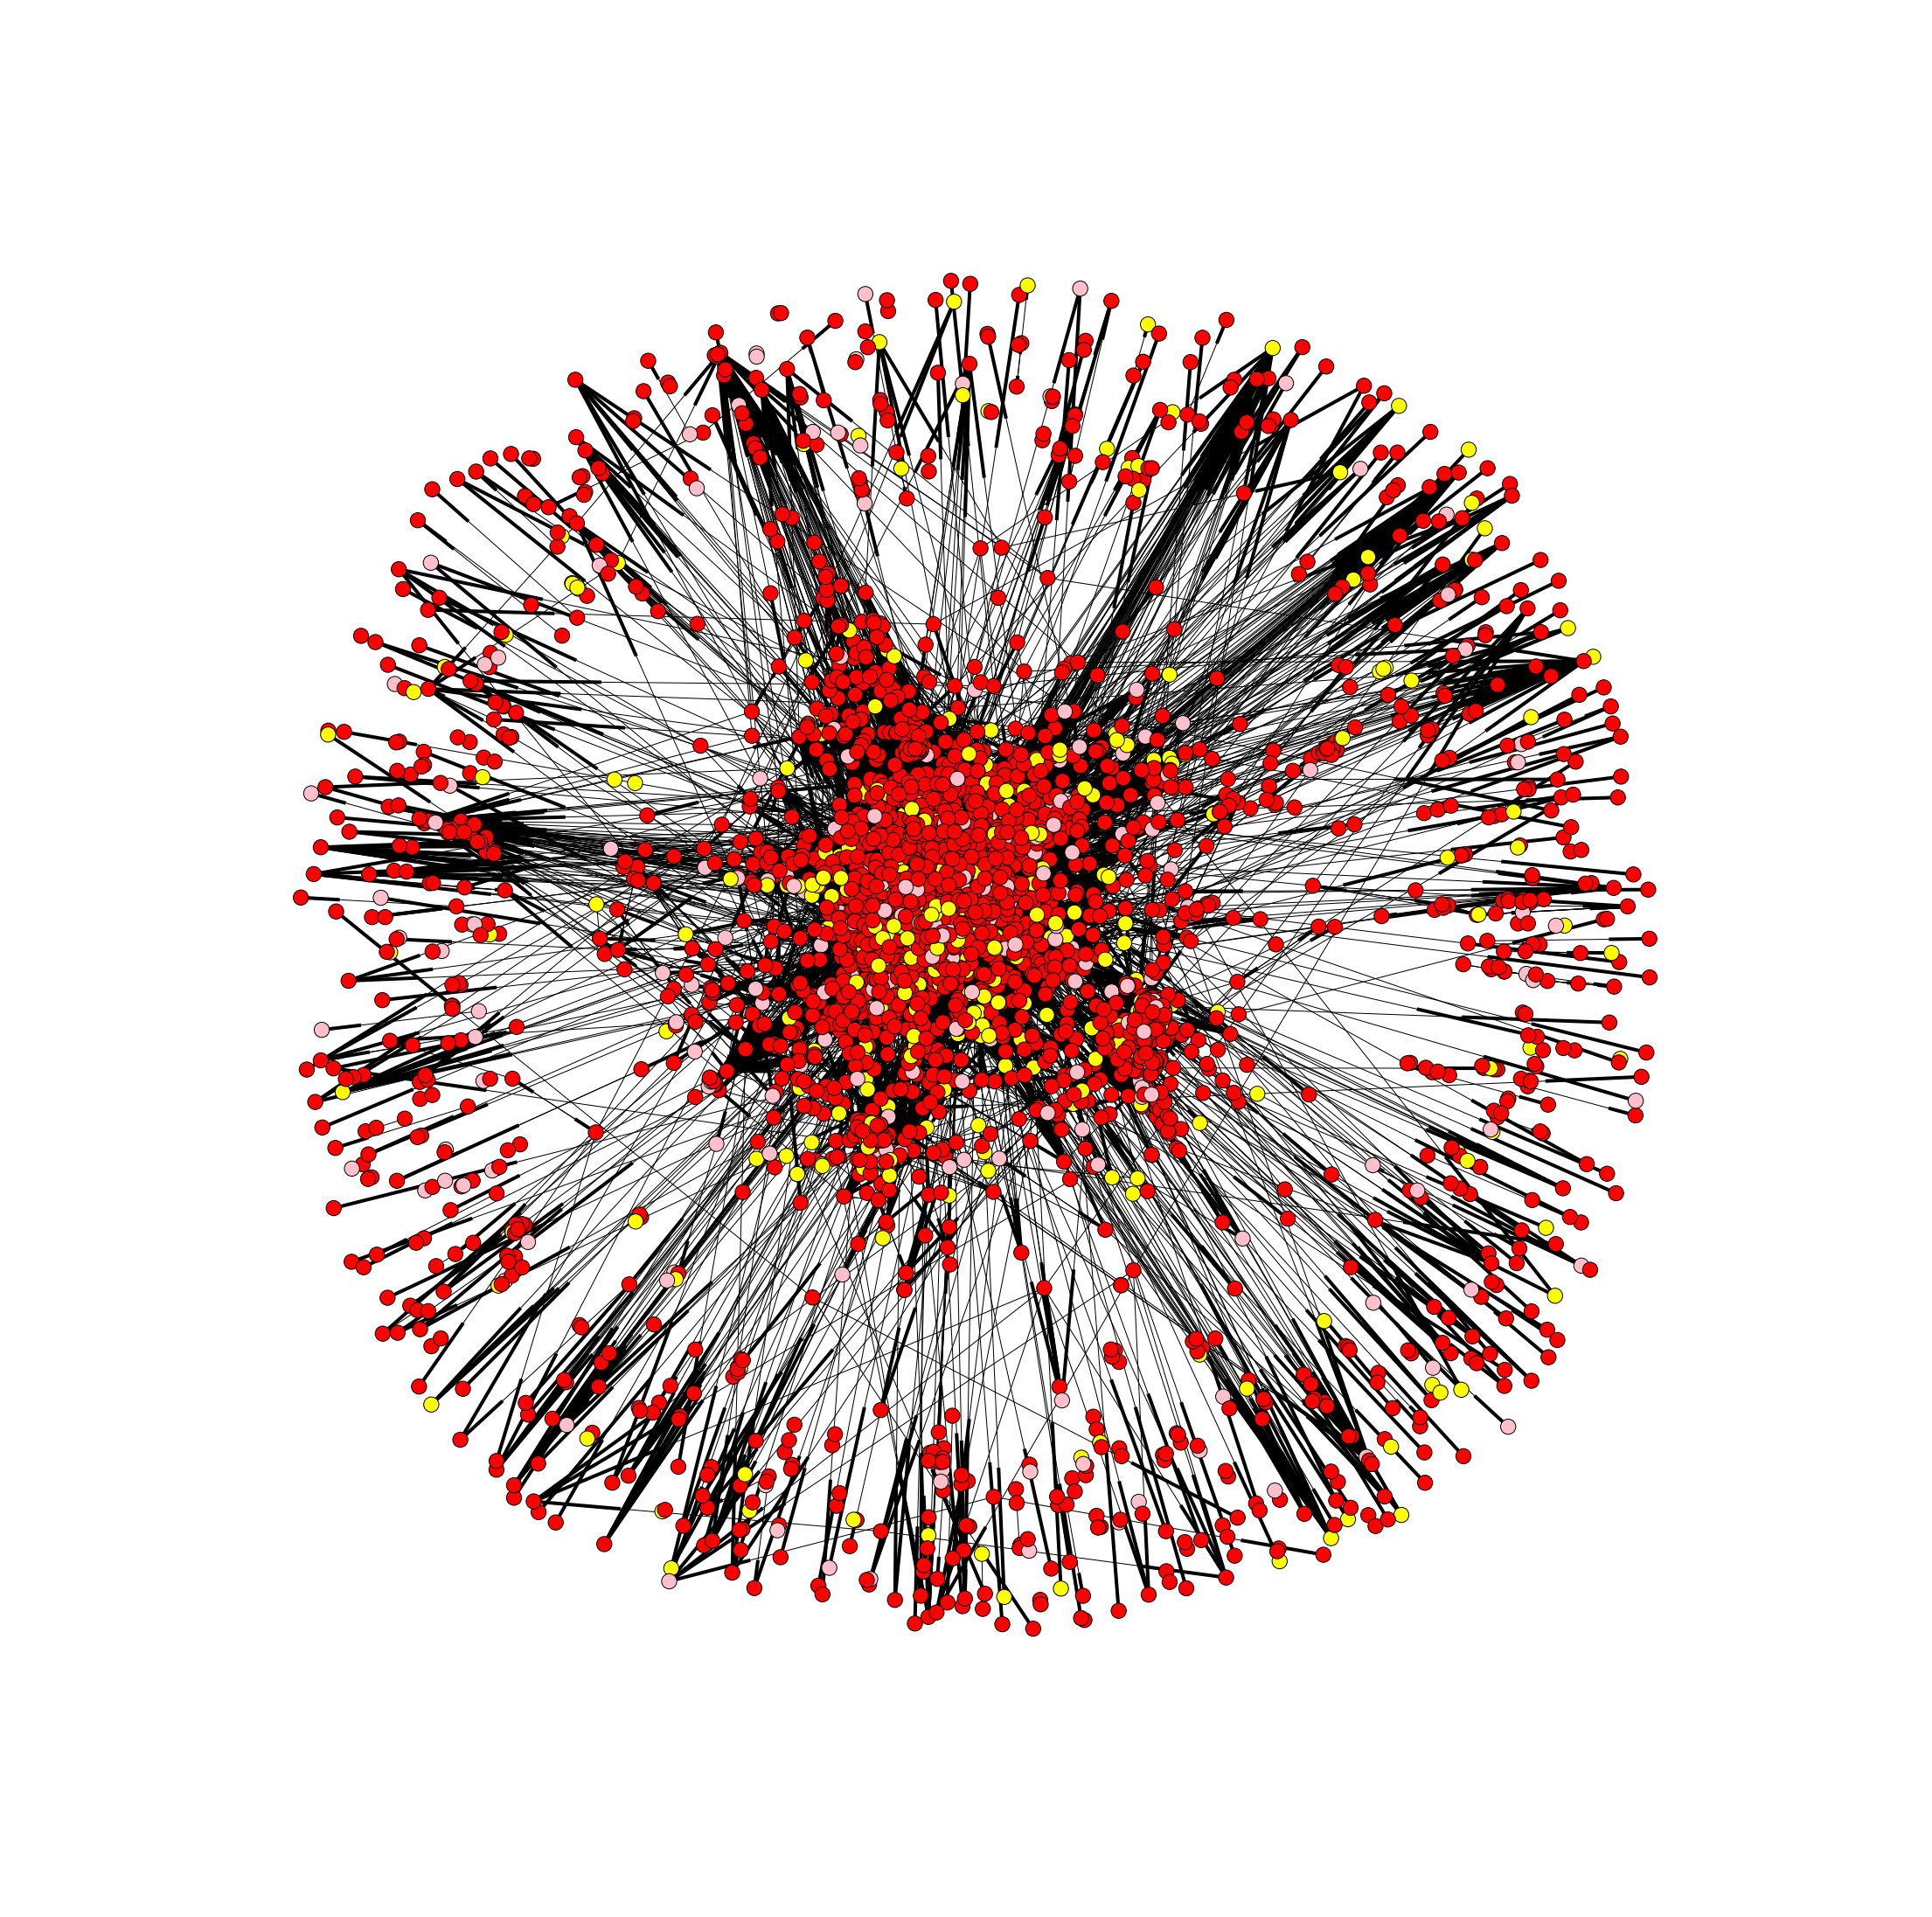

In [156]:
plt.figure(figsize=(30,30))
nx.draw(G,node_color=color_map)
plt.show()